# Forest cover classification

There are 7 diferent types of covers into which the data will be classified:
* Spruce/Fir
* Lodgepole Pine
* Ponderosa Pine
* Cottonwood/Willow
* Aspen
* Douglas-fir
* Krummholz

The model uses a Sequential arquitecture.

In [157]:
import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

***Import and preprocess the data***

The last data point of each line of the .csv is the type of cover the line represents.

In [158]:
data = pd.read_csv('cover_data.csv')
print(data.info())

#Extract the last column from the data pandas dataframe, which is the label
cover_type = data["class"]
#Extract from the first to penuultimate column from the data pandas dataframe
caracteristics = data.iloc[:,0:-1]

#Perform one-hot encoding
caracteristics = pd.get_dummies(caracteristics)

#Split the data
x_train, x_test, y_train, y_test = train_test_split(caracteristics, cover_type, train_size=0.30, random_state=42, stratify=cover_type)

#Enconde and transform data with labels
#Only the numeric columns are scaled
numeric_columns = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
cp = ColumnTransformer([("numeric", StandardScaler(), numeric_columns)])
x_train = cp.fit_transform(x_train)
x_test = cp.transform(x_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

***Create the model***

In [159]:
#Function to create the model
def create_model(x_train):
    model = keras.models.Sequential()

    #Input layer
    model.add(keras.layers.InputLayer(input_shape=(x_train.shape[1])))

    #Hidden layers
    model.add(keras.layers.Dense(28, activation='relu'))
    model.add(keras.layers.Dense(56, activation='sigmoid'))
    model.add(keras.layers.Dense(14, activation='tanh'))

    #Output layer (use softmax for classification)
    model.add(keras.layers.Dense(7, activation='softmax'))

    return model

#Create and compile the model
model = create_model(x_train)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.008), metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.AUC(name='val_auc')])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20, mode='min', verbose=1)

#Fit the model to the training data
history = model.fit(
    x_train,
    y_train,
    epochs=400,
    batch_size=2000
)

Epoch 1/400
88/88 [==============================] - 1s 2ms/step - loss: 0.9588 - categorical_accuracy: 0.6381 - val_auc: 0.9225
Epoch 2/400
88/88 [==============================] - 0s 2ms/step - loss: 0.7077 - categorical_accuracy: 0.7038 - val_auc: 0.9550
Epoch 3/400
88/88 [==============================] - 0s 2ms/step - loss: 0.6685 - categorical_accuracy: 0.7132 - val_auc: 0.9586
Epoch 4/400
88/88 [==============================] - 0s 2ms/step - loss: 0.6463 - categorical_accuracy: 0.7184 - val_auc: 0.9609
Epoch 5/400
88/88 [==============================] - 0s 2ms/step - loss: 0.6301 - categorical_accuracy: 0.7242 - val_auc: 0.9626
Epoch 6/400
88/88 [==============================] - 0s 2ms/step - loss: 0.6167 - categorical_accuracy: 0.7296 - val_auc: 0.9640
Epoch 7/400
88/88 [==============================] - 0s 2ms/step - loss: 0.6049 - categorical_accuracy: 0.7364 - val_auc: 0.9653
Epoch 8/400
88/88 [==============================] - 0s 3ms/step - loss: 0.5943 - categorical_acc

***Make predictions with the model***

In [160]:
y_estimate = model.predict(x_test, verbose=0)
y_estimate = np.argmax(y_estimate, axis=1)
y_true = np.argmax(y_test, axis=1)

print(sklearn.metrics.classification_report(y_true, y_estimate))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84    148288
           1       0.86      0.88      0.87    198311
           2       0.82      0.76      0.79     25028
           3       0.81      0.56      0.66      1923
           4       0.75      0.47      0.58      6645
           5       0.63      0.70      0.66     12157
           6       0.88      0.79      0.83     14357

    accuracy                           0.84    406709
   macro avg       0.80      0.71      0.75    406709
weighted avg       0.84      0.84      0.84    406709



***Plot the results by epoch to visualize performance***

Two subplots, one for the categorical accuracy and one for the AUC of the ROC curve.

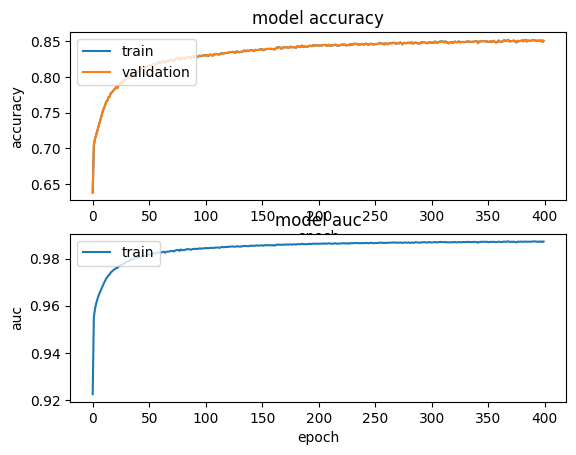

In [161]:
fig = plt.figure()
axis1 = fig.add_subplot(2,1,1)
axis1.plot(history.history['categorical_accuracy'])
axis1.plot(history.history['categorical_accuracy'])
axis1.set_title('model accuracy')
axis1.set_xlabel('epoch')
axis1.set_ylabel('accuracy')
axis1.legend(['train', 'validation'], loc='upper left')

#AUC validation
axis2 = fig.add_subplot(2,1,2)
#axis2.plot(history.history['auc'])
axis2.plot(history.history['val_auc'])
axis2.set_title('model auc')
axis2.set_xlabel('epoch')
axis2.set_ylabel('auc')
axis2.legend(['train', 'validation'], loc='upper left')

plt.show()

fig.tight_layout()